# Assessment Task 1

## Set up environment

In [1]:
# Load required packages
import pandas as pd
import numpy as np
from joblib import dump
from joblib import load
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt 
from pandas_profiling import ProfileReport

## Get data

In [2]:
# Import and inspect training data
df_train = pd.read_csv('../../data/raw/train.csv')
display(df_train)

# Import and inspect test data
df_test = pd.read_csv('../../data/raw/test.csv')
display(df_test)

,Id_old,Id,GP,MIN,PTS,FGM,FGA,FG%,3P_Made,3PA,...,FTA,FT%,OREB,DREB,REB,AST,STL,BLK,TOV,TARGET_5Yrs
0,10556,3799,80,24.3,7.8,3.0,6.4,45.7,0.1,0.3,...,2.9,72.1,2.2,2.0,3.8,3.2,1.1,0.2,1.6,1
1,5342,3800,75,21.8,10.5,4.2,7.9,55.1,-0.3,-1.0,...,3.6,67.8,3.6,3.7,6.6,0.7,0.5,0.6,1.4,1
2,5716,3801,85,19.1,4.5,1.9,4.5,42.8,0.4,1.2,...,0.6,75.7,0.6,1.8,2.4,0.8,0.4,0.2,0.6,1
3,13790,3802,63,19.1,8.2,3.5,6.7,52.5,0.3,0.8,...,1.5,66.9,0.8,2.0,3.0,1.8,0.4,0.1,1.9,1
4,5470,3803,63,17.8,3.7,1.7,3.4,50.8,0.5,1.4,...,0.5,54.0,2.4,2.7,4.9,0.4,0.4,0.6,0.7,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7995,2996,11794,32,9.2,1.8,0.7,1.8,40.3,-0.1,-0.2,...,0.6,65.7,0.3,1.8,1.9,0.5,0.3,0.2,0.4,1
7996,11679,11795,54,6.0,1.8,0.7,1.4,48.7,0.1,0.1,...,0.4,70.1,1.0,1.1,2.0,0.1,0.0,0.3,0.3,1
7997,5537,11796,85,28.2,10.7,4.0,9.0,45.1,0.2,0.6,...,3.9,69.7,1.0,2.1,3.1,3.4,1.2,0.2,1.8,1
7998,1292,11797,39,7.7,2.5,1.0,2.3,40.1,-0.3,-0.5,...,0.7,74.3,0.4,0.6,0.9,0.2,0.3,0.3,0.5,1


,Id_old,Id,GP,MIN,PTS,FGM,FGA,FG%,3P_Made,3PA,...,FTM,FTA,FT%,OREB,DREB,REB,AST,STL,BLK,TOV
0,1,0,56,9.1,4.0,1.6,3.7,43.7,0.1,0.3,...,0.7,1.2,63.4,1.2,0.8,1.7,0.4,0.2,0.3,0.8
1,8194,1,43,19.3,10.1,3.7,8.1,46.0,0.6,1.7,...,1.8,2.5,75.3,0.5,0.9,1.5,3.5,0.6,0.0,1.8
2,3,2,82,33.9,11.3,4.9,10.6,45.6,0.5,1.9,...,1.8,2.7,71.2,1.3,3.3,4.5,2.5,1.3,0.3,2.0
3,8196,3,86,44.7,18.8,6.8,15.9,42.9,0.5,1.8,...,4.5,6.3,70.9,1.5,3.2,5.0,4.1,0.9,0.1,3.6
4,8197,4,58,12.3,4.7,1.6,4.0,40.0,0.5,1.7,...,1.1,1.3,76.9,0.2,0.6,0.9,1.5,0.5,-0.4,0.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3794,8175,3794,84,21.2,8.7,3.4,6.7,50.2,0.0,0.0,...,1.7,2.5,68.1,1.9,2.3,3.9,1.5,0.6,0.3,2.0
3795,8176,3795,49,16.3,6.4,2.9,6.6,44.4,-0.1,-0.4,...,1.0,1.9,50.2,1.7,2.8,4.4,0.4,0.4,0.4,0.7
3796,8178,3796,53,9.9,2.1,0.8,1.8,43.1,-0.4,-0.6,...,0.6,1.0,63.9,0.7,1.0,1.7,0.4,0.4,0.2,0.5
3797,8181,3797,89,38.3,14.5,5.4,11.8,45.2,0.5,1.2,...,2.5,2.9,89.2,1.5,4.0,5.5,3.7,1.3,0.3,2.4


## Data exploration

## Data manipulation

In [3]:
# Drop ID column - training data
df_train = df_train.drop(['Id_old','Id'], axis=1)

# Identify target
features = df_train.iloc[:,:-1].to_numpy()
target = df_train.iloc[:,-1].to_numpy()

# Standardize features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
features = scaler.fit_transform(features)

# Save scaler into models folder
dump(scaler, '../../models/David/scaler.joblib')

# Split into training and validation sets
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(features, target, test_size=0.2, random_state=8)

In [4]:
# Drop ID column - test data
df_test = df_test.drop(['Id_old','Id'], axis=1)

# Standardize features - test data
X_test = scaler.fit_transform(df_test)

In [5]:
# Save split datasets into data folder
#np.save('../../data/processed/X_train', X_train)
#np.save('../../data/processed/X_val', X_val)
#np.save('../../data/processed/y_train', y_train)
#np.save('../../data/processed/y_val', y_val)
#np.save('../../data/processed/X_test', X_test)

## Set up experiment space

In [13]:
def plot_matrix_curve(reg):
    
    # Print confusion matrix to evaluate classification accuracy
    plot_confusion_matrix(reg, X_train, y_train, 
                          cmap=plt.cm.Blues,
                          colorbar=False,
                          normalize='true')
    plt.title("Confusion matrix - Training data")
    plt.show() 

    plot_confusion_matrix(reg, X_val, y_val,
                          cmap=plt.cm.Blues,
                          colorbar=False,
                          normalize='true')
    plt.title("Confusion matrix - Validation data")
    plt.show() 
    
    # Calculate and plot ROC_AUC
    y_score = reg.predict_proba(X_val)[:,1]
    roc_auc_val = roc_auc_score(y_val, y_score)
    print("ROC_AUC:", roc_auc_val)
    reg_disp = plot_roc_curve(reg, X_val, y_val)
    
    #return reg_disp


In [34]:
def save_reg_perf \
    ( targ:np.real
    , pred:np.real
    , prob:np.real 
    , name:str=None
    , df_metrics:pd.DataFrame=None
    , overwrite:bool=True
    , print:bool=True
    , print_matrix:bool=True
    , print_plot:bool=True
    , print_dataframe:bool=True
    ):
    """
    Save model metrics to a dataframe.

    Args:
        pred (np.real): The prediction values. Can be scalar or array, but must be Real numbers.
        targ (np.real): The actual values. Can be scalar or arrya, but must be Real numbers.
        name (str, optional): The name of the data being calculated. If not given, will default to 'None'. Defaults to None.
        df_metrics (pd.DataFrame, optional): The data frame to be updated to contain the data. If not given, will update the `pred_scor` dataframe from the global scope. Defaults to None.
        overwrite (bool, optional): Whether or not to overwrite the data in the dataframe. In SQL-speak: True=UPDATE, False=INSERT. Defaults to True.
        print (bool, optional): Wheather or not to turn off all printing. Defaults to True.
        print_dataframe (bool, optional): Whether or not to print the final updated dataframe. Defaults to True.

    Raises:
        Assertions: Each parameter will be asserted to the proper type and attribute.

    Returns:
        pd.DataFrame: The updated dataframe.
    """    
    
    # Imports
    import numpy as np
    import pandas as pd
    from sklearn.metrics import roc_auc_score as auc
    from sklearn.metrics import confusion_matrix as conf
    from sklearn.metrics import f1_score as f1

    # Assertions
    assert np.all(np.isreal(pred))
    assert np.all(np.isreal(targ))
    for parameter in [overwrite, print_dataframe]:
        assert isinstance(parameter, bool)
    if not name==None:
        assert np.isscalar(name)
        assert isinstance(name, str)
    if not df_metrics==None:
        assert isinstance(df_metrics, pd.DataFrame)
        assert df_metrics.columns == ["name","when","auc","sens","spec","f1"]

    # Ensure we're using the global object here
    global pred_scor

    # If you want to use another dataframe, go right ahead. Else, just keep it simple.
    if df_metrics==None: df = pred_scor
    else: df = df_metrics
    
    # Best to define name, but if blank then make None
    if name==None: name=="None"

    # Perform calculations
    val_now = pd.Timestamp.now().strftime('%d/%b %H:%M')
    tn, fp, fn, tp = conf(targ,pred).ravel()
    val_auc = round(auc(targ,prob), 5)
    val_sens = round(tp/(tp+fn), 5)
    val_spec = round(tn/(tn+fp), 5)
    val_f1 = round(f1(targ,pred), 5)

    # Two different methods of updating the table. In SQL-Speak this is the difference between INSERT and UPDATE
    if overwrite and name in df["name"].to_numpy():
        df.loc[df["name"] == name, ["when"]] = val_now
        df.loc[df["name"] == name, ["auc"]] = val_auc
        df.loc[df["name"] == name, ["sens"]] = val_sens
        df.loc[df["name"] == name, ["spec"]] = val_spec
        df.loc[df["name"] == name, ["f1"]] = val_f1
    else:
        new = pd.DataFrame \
            (
                { "name": [name]
                , "when": [val_now]
                , "auc": [val_auc]
                , "sens": [val_sens]
                , "spec": [val_spec]
                , "f1": [val_f1]
                }
            )
        df = df.append(new)

    # Fix Pandas indexes
    df.reset_index(drop=True, inplace=True)

    # Assign back to the global scope
    pred_scor = df

    # Print if needed
    if print:
        if print_dataframe:
            display(df)

    # Return
    return df

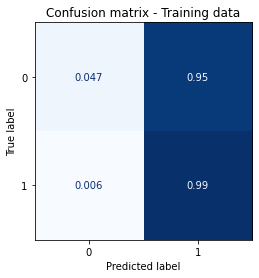

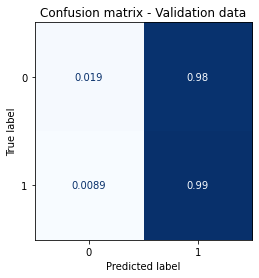

ROC_AUC: 0.7073251996952058


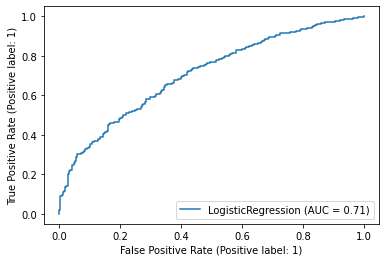

In [14]:
plot_matrix_curve(log_reg)

In [32]:
prob = log_reg.predict(X_val)

In [35]:
save_reg_perf(y_val, X_val, prob, "Logistic Regression")

ValueError: Classification metrics can't handle a mix of binary and continuous-multioutput targets

## Experimentation

### Linear SVC

In [ ]:
from sklearn.svm import SVC

linear_svc = SVC(kernel = 'linear', probability=True)

linear_svc.fit(X_train, y_train)

In [ ]:
# Save fitted model into model folder
dump(linear_svc,  '../../models/David/linear_svc.joblib')

In [ ]:
# Model predictions on training and validation data
y_train_pred = linear_svc.predict(X_train)
y_val_pred = linear_svc.predict(X_val)

In [ ]:
# Print confusion matrix to evaluate classification accuracy
plot_confusion_matrix(linear_svc, X_train, y_train, 
                      cmap=plt.cm.Blues,
                     colorbar=False,
                     normalize='true')
plt.title("Confusion matrix - Training data")
plt.show() 

plot_confusion_matrix(linear_svc, X_val, y_val,
                      cmap=plt.cm.Blues,
                     colorbar=False,
                     normalize='true')
plt.title("Confusion matrix - Validation data")
plt.show() 

In [ ]:
# Calculate and plot ROC_AUC
y_score = linear_svc.predict_proba(X_val)[:,1]
roc_auc_val = roc_auc_score(y_val, y_score)
print("ROC_AUC:", roc_auc_val)
log_reg_disp = plot_roc_curve(linear_svc, X_val, y_val)

In [ ]:
save_reg_perf(pred_val, targ_val, "LogisticRegression - Defaults")

### K Neighbours

In [ ]:
# Create and fit classifier
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(X_train, y_train)

In [ ]:
# Save fitted model into model folder
dump(neigh,  '../../models/David/neigh.joblib')

In [ ]:
# Model predictions on training and validation data
y_train_pred = neigh.predict(X_train)
y_val_pred = neigh.predict(X_val)

In [ ]:
# Print confusion matrix to evaluate classification accuracy
plot_confusion_matrix(neigh, X_train, y_train, 
                      cmap=plt.cm.Blues,
                     colorbar=False,
                     normalize='true')
plt.title("Confusion matrix - Training data")
plt.show() 

plot_confusion_matrix(neigh, X_val, y_val,
                      cmap=plt.cm.Blues,
                     colorbar=False,
                     normalize='true')
plt.title("Confusion matrix - Validation data")
plt.show() 

In [ ]:
# Calculate and plot ROC_AUC
y_score = neigh.predict_proba(X_val)[:,1]
roc_auc_val = roc_auc_score(y_val, y_score)
print("ROC_AUC:", roc_auc_val)
log_reg_disp = plot_roc_curve(neigh, X_val, y_val)

### Logistic Regression - default

In [6]:
# Create and fit classifier
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)

LogisticRegression()

In [7]:
# Save fitted model into model folder
dump(log_reg,  '../../models/David/log_reg.joblib')

['../../models/David/log_reg.joblib']

In [8]:
# Model predictions on training and validation data
y_train_pred = log_reg.predict(X_train)
y_val_pred = log_reg.predict(X_val)

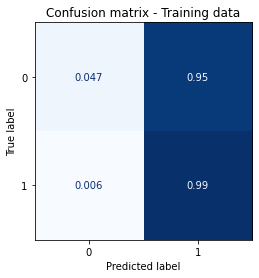

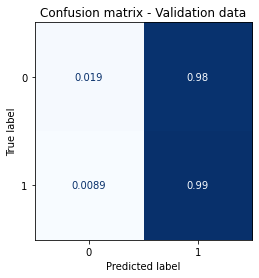

In [9]:
# Print confusion matrix to evaluate classification accuracy
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(log_reg, X_train, y_train, 
                      cmap=plt.cm.Blues,
                     colorbar=False,
                     normalize='true')
plt.title("Confusion matrix - Training data")
plt.show() 

plot_confusion_matrix(log_reg, X_val, y_val,
                      cmap=plt.cm.Blues,
                     colorbar=False,
                     normalize='true')
plt.title("Confusion matrix - Validation data")
plt.show() 

ROC_AUC: 0.7073251996952058


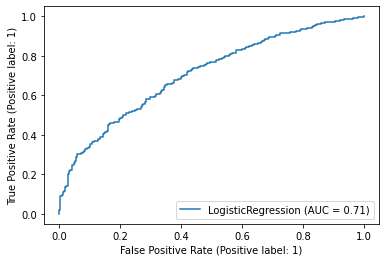

In [10]:
# Calculate and plot ROC_AUC
y_score = log_reg.predict_proba(X_val)[:,1]
roc_auc_val = roc_auc_score(y_val, y_score)
print("ROC_AUC:", roc_auc_val)
log_reg_disp = plot_roc_curve(log_reg, X_val, y_val)

### Logistic Regression - ElasticNet

In [ ]:
# Create and fit classifier
from sklearn.linear_model import LogisticRegression 

log_reg_elastic = LogisticRegression(
    penalty='elasticnet', 
    solver='saga', 
    l1_ratio=0.5)

log_reg_elastic.fit(X_train, y_train)

In [ ]:
# Save fitted model into model folder
dump(log_reg_elastic,  '../../models/David/log_reg_elastic.joblib')

In [ ]:
# Model predictions on training and validation data
y_train_pred = log_reg_elastic.predict(X_train)
y_val_pred = log_reg_elastic.predict(X_val)

In [ ]:
# Print confusion matrix to evaluate classification accuracy
plot_confusion_matrix(log_reg_elastic, X_train, y_train, 
                      cmap=plt.cm.Blues,
                     colorbar=False,
                     normalize='true')
plt.title("Confusion matrix - Training data")
plt.show() 

plot_confusion_matrix(log_reg_elastic, X_val, y_val,
                      cmap=plt.cm.Blues,
                     colorbar=False,
                     normalize='true')
plt.title("Confusion matrix - Validation data")
plt.show() 

In [ ]:
# Calculate and plot ROC_AUC
y_score = log_reg_elastic.predict_proba(X_val)[:,1]
roc_auc_val = roc_auc_score(y_val, y_score)
print("ROC_AUC:", roc_auc_val)
log_reg_disp = plot_roc_curve(log_reg_elastic, X_val, y_val)

### Logistic Regression CV

In [ ]:
# Create and fit classifier
from sklearn.linear_model import LogisticRegressionCV 

C_list = np.linspace(0.001, 0.5, 20)

log_reg_cv = LogisticRegressionCV(
    Cs=C_list, 
    cv=20,
    penalty='l1',
    scoring='roc_auc', 
    solver='liblinear',
    tol =1e-4, 
    max_iter=1000, 
    class_weight='balanced', 
    n_jobs=10, #7
    verbose=2, 
    refit=True, 
    multi_class='ovr', 
    random_state=42)

log_reg_cv.fit(X_train, y_train)

In [ ]:
# Save fitted model into model folder
dump(log_reg_cv,  '../../models/David/log_reg_cv.joblib')

In [ ]:
# Model predictions on training and validation data
y_train_pred = log_reg_cv.predict(X_train)
y_val_pred = log_reg_cv.predict(X_val)

In [ ]:
# Print confusion matrix to evaluate classification accuracy
plot_confusion_matrix(log_reg_cv, X_train, y_train, 
                      cmap=plt.cm.Blues,
                     colorbar=False,
                     normalize='true')
plt.title("Confusion matrix - Training data")
plt.show() 

plot_confusion_matrix(log_reg_cv, X_val, y_val,
                      cmap=plt.cm.Blues,
                     colorbar=False,
                     normalize='true')
plt.title("Confusion matrix - Validation data")
plt.show() 

In [ ]:
# Calculate and plot ROC_AUC
y_score = log_reg_cv.predict_proba(X_val)[:,1]
roc_auc_val = roc_auc_score(y_val, y_score)
print("ROC_AUC:", roc_auc_val)
log_reg_disp = plot_roc_curve(log_reg_cv, X_val, y_val)

### Random Forest - default

In [ ]:
# Create and fit classifier
from sklearn.ensemble import RandomForestClassifier

random_forest = RandomForestClassifier()

random_forest.fit(X_train, y_train)

In [ ]:
# Save fitted model into model folder
dump(random_forest,  '../../models/David/random_forest.joblib')

In [ ]:
# Model predictions on training and validation data
y_train_pred = random_forest.predict(X_train)
y_val_pred = random_forest.predict(X_val)

In [ ]:
# Print confusion matrix to evaluate classification accuracy
plot_confusion_matrix(random_forest, X_train, y_train, 
                      cmap=plt.cm.Blues,
                     colorbar=False,
                     normalize='true')
plt.title("Confusion matrix - Training data")
plt.show() 

plot_confusion_matrix(random_forest, X_val, y_val,
                      cmap=plt.cm.Blues,
                     colorbar=False,
                     normalize='true')
plt.title("Confusion matrix - Validation data")
plt.show() 

In [ ]:
# Calculate and plot ROC_AUC
y_score = random_forest.predict_proba(X_val)[:,1]
roc_auc_val = roc_auc_score(y_val, y_score)
print("ROC_AUC:", roc_auc_val)
log_reg_disp = plot_roc_curve(random_forest, X_val, y_val)

### Random Forest - second attempt

In [ ]:
# Create and fit classifier
from sklearn.ensemble import RandomForestClassifier

random_forest2 = RandomForestClassifier(
    n_estimators=5, 
    criterion='entropy', 
    max_depth=15, 
    min_samples_split=3, 
    random_state=42, 
    verbose=1, 
    class_weight='balanced' 
)

random_forest2.fit(X_train, y_train)

In [ ]:
# Save fitted model into model folder
dump(random_forest2,  '../../models/David/random_forest2.joblib')

In [ ]:
# Model predictions on training and validation data
y_train_pred = random_forest2.predict(X_train)
y_val_pred = random_forest2.predict(X_val)

In [ ]:
# Print confusion matrix to evaluate classification accuracy
plot_confusion_matrix(random_forest2, X_train, y_train, 
                      cmap=plt.cm.Blues,
                     colorbar=False,
                     normalize='true')
plt.title("Confusion matrix - Training data")
plt.show() 

plot_confusion_matrix(random_forest2, X_val, y_val,
                      cmap=plt.cm.Blues,
                     colorbar=False,
                     normalize='true')
plt.title("Confusion matrix - Validation data")
plt.show() 

In [ ]:
# Calculate and plot ROC_AUC
y_score = random_forest2.predict_proba(X_val)[:,1]
roc_auc_val = roc_auc_score(y_val, y_score)
print("ROC_AUC:", roc_auc_val)
log_reg_disp = plot_roc_curve(random_forest2, X_val, y_val)

### Support Vector Classification - default

In [ ]:
# Create and fit classifier
from sklearn.svm import SVC

svm = SVC(kernel = 'sigmoid', probability=True)

svm.fit(X_train, y_train)

In [ ]:
# Save fitted model into model folder
dump(svm,  '../../models/David/svm.joblib')

In [ ]:
# Model predictions on training and validation data
y_train_pred = svm.predict(X_train)
y_val_pred = svm.predict(X_val)

In [ ]:
# Print confusion matrix to evaluate classification accuracy

plt.subplot(1,2,1)
cm_train = plot_confusion_matrix(svm, X_train, y_train, 
                      cmap=plt.cm.Blues,
                     colorbar=False,
                     normalize='true')
cm_train.plot
plt.title("Confusion matrix - Training data") 

plt.subplot(1,2,2)
plot_confusion_matrix(svm, X_val, y_val,
                      cmap=plt.cm.Blues,
                     colorbar=False,
                     normalize='true')
plt.title("Confusion matrix - Validation data")
plt.show() 

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Horizontally stacked subplots')
ax1.plot_confusion_matrix(svm, X_train, y_train, 
                      cmap=plt.cm.Blues,
                     colorbar=False,
                     normalize='true')
ax2.plot_confusion_matrix(svm, X_val, y_val,
                      cmap=plt.cm.Blues,
                     colorbar=False,
                     normalize='true')

In [ ]:
# Calculate and plot ROC_AUC
y_score = svm.predict_proba(X_val)[:,1]
roc_auc_val = roc_auc_score(y_val, y_score)
print("ROC_AUC:", roc_auc_val)
log_reg_disp = plot_roc_curve(svm, X_val, y_val)

## Calculate and export test data predictions

In [ ]:
# Predict target probabilities (use specific model name)
test_probs = log_reg_cv.predict_proba(X_test)[:,1]

In [ ]:
# Create dataframe object
test_probs_df = pd.DataFrame(test_probs, columns = ["TARGET_5Yrs"])

# Name 'ID' column
test_probs_df.index.name = "Id"

In [ ]:
# Save output to csv
test_probs_df.to_csv("final.csv")